<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/getting_started_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference using IceVision

![](https://raw.githubusercontent.com/airctic/icevision/master/images/fridge-objects.png)

## Install IceVision
The following downloads and runs a short shell script. The script installs IceVision, IceData, the MMDetection library, and Yolo v5 as well
as the fastai and pytorch lightning engines.

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

## Imports
All of the IceVision components can be easily imported with a single line.


In [ ]:
from icevision.all import *

## List of images for inference

Please store your images in a folder, and populate the `path_to_folder` variable with the corresponding folder name.

In [2]:
# Pick your images folder
path_to_folder = "../samples/fridge/odFridgeObjects/images"
img_files = get_image_files(path_to_folder)
# img_files

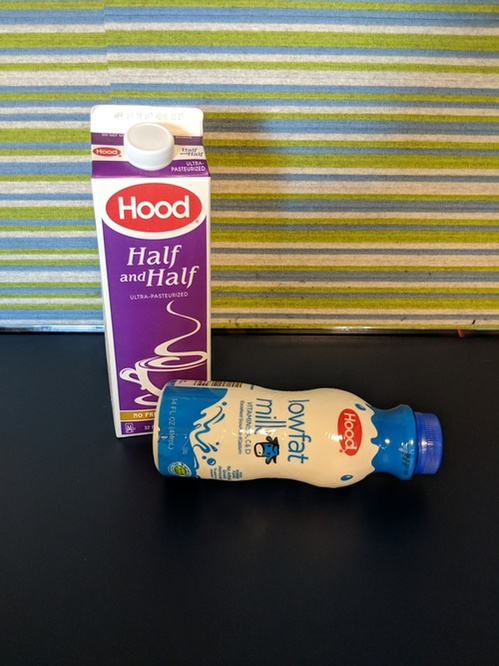

In [3]:
img = PIL.Image.open(img_files[0])
img

## Loading a checkpoint and creating the corresponding model

The checkpoint file can either a local file or an URL

In [ ]:
# checkpoint_path = 'checkpoints/fridge-retinanet-save-checkpoint-full.pth'
checkpoint_path = 'https://github.com/airctic/model_zoo/releases/download/m6/fridge-retinanet-checkpoint-full.pth'
checkpoint_and_model = model_from_checkpoint(checkpoint_path)

In [5]:
# Just logging the info
model_type = checkpoint_and_model["model_type"]
backbone = checkpoint_and_model["backbone"]
class_map = checkpoint_and_model["class_map"]
img_size = checkpoint_and_model["img_size"]
model_type, backbone, class_map, img_size

(<module 'icevision.models.mmdet.models.retinanet' from '/home/farid/repos/airctic/icevision/icevision/models/mmdet/models/retinanet/__init__.py'>,
 <ClassMap: {'background': 0, 'carton': 1, 'milk_bottle': 2, 'can': 3, 'water_bottle': 4}>,
 384)

## Get Model Object

`model_from_checkpoint(checkpoint_path)` returns a dictionary: `checkpoint_and_model`.The model object is stored in `checkpoint_and_model["model"]`.

In [6]:
# Get model object
model = checkpoint_and_model["model"]

# Check device
device=next(model.parameters()).device
device

device(type='cpu')

## Set Set model to eval mode

>  You must set model to eval mode. Otherwise predictions will be wrong.

In [7]:
model.eval()

RetinaNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [8]:
# Transforms
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

## Single Image Inference

The `end2end_detect()` not only compute predictions for a single image but also automatically adjust predicted boxes to the original image size

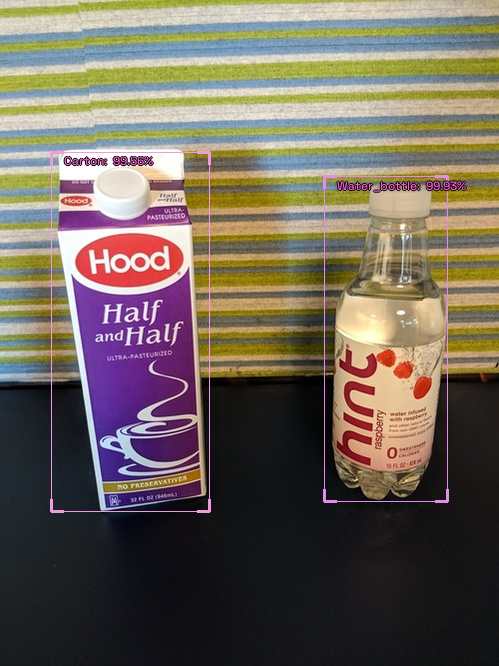

In [9]:
img = PIL.Image.open(img_files[1])

pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.8)
pred_dict['img']

## Batch Inference

The following option shows to do generate inference for a set of images. The latter is processed in batches.

In [10]:
# Create a dataset
imgs_array = [PIL.Image.open(Path(fname)) for fname in img_files]
infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map=class_map)

# Batch Inference
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)
preds_saved = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/2 [00:00<?, ?it/s]

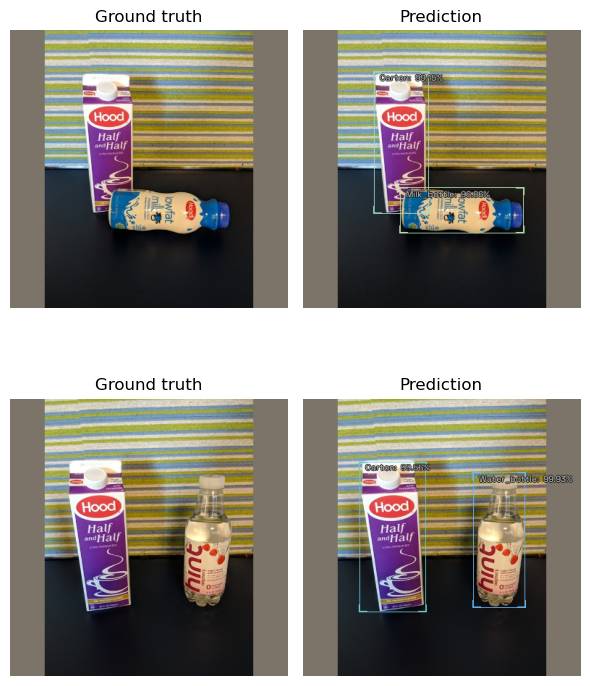

In [11]:
show_preds(preds=preds_saved[0:2])

## How to save a model and its metadata in IceVision

In [14]:
# How to save a model and its metadata
checkpoint_path = 'checkpoints/fridge-retinanet-checkpoint-full.pth'

save_icevision_checkpoint(model, 
                        model_name='mmdet.retinanet', 
                        backbone_name='resnet50_fpn_1x',
                        class_map =  class_map, 
                        img_size=img_size, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.9.1a1'})

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).